# Plot Lyapunov exponents and Eigenvalues for Active Filament simulations

In [3]:
import sys
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import pyfilaments.analysisutils as analysis
from pyfilaments._def_analysis import *
import pandas as pd
import h5py

from joblib import Parallel, delayed
import multiprocessing
%matplotlib notebook
plt.close('all')
# Create a folder for storing Publication figures
publication_figures = '/home/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures/Figure3'

import _figure_parameters

linux system
dict_keys(['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconfig', '_sysconfigdata_m_linux_x86_64-linux-gnu', 'types', 'functools', '_functools', 'collections', 'operator', '_operator', 'keyword', 'heapq', '_heapq', 'itertools', 'reprlib', '_collections', 'weakref', 'collections.abc', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib.util', 'importlib.abc', 'importlib.machinery', 'contextlib', 'mpl_toolkits', 'sphinxcontrib', 'runpy', 'pkgutil', 'ipykernel', 'ipykernel._version', 'ipykernel.connect', '__future__', 'json', 'json.decoder', '

# No:of Significant Eigenvalues Plot

### Choose the data to analyze

In [3]:
# batch_analysis_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23'

batch_analysis_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweeps_diffActivityTimeScales_FINAL/activityTime_750'
parameter = 'potDipole strength'


In [5]:

df_sig_eigenvalues = pd.DataFrame({})

for root, dirs, files in os.walk(batch_analysis_folder):
    
    for file in files:
                
        if('eigenvectors' in file and file.endswith('.hdf5')):
            
            with h5py.File(os.path.join(root, file), "r") as f:

                dset = f['eigenvectors']

                eigenvalues_sig = dset['eigenvalues'][:]
                eigenvectors_sig = dset['eigenvectors'][:]
                pca_dim = dset.attrs['PCA dimension']
                
                n_sig_eigenvalues = len(eigenvalues_sig)
                
                # Load metadata
                base_folder, *rest = os.path.split(root)
                
                df_metadata = pd.read_csv(os.path.join(base_folder, 'metadata.csv'))
                
                # activity number
                viscosity = df_metadata[' viscosity'][0]
                L = (df_metadata['N particles'][0]-1)*df_metadata['bond length'][0]
                kappa = df_metadata['kappa_hat'][0]*df_metadata['bond length'][0]
                radius = df_metadata['radius'][0]
                D0 = df_metadata['potDipole strength'][0]

                activity_number = (viscosity*radius**3*L**2*D0/kappa)
                
                parameter_value = df_metadata[parameter][0]
                
                df_sig_eigenvalues = df_sig_eigenvalues.append(pd.DataFrame({parameter:[parameter_value], 'activity number':activity_number, 'N sig eigenvalues':[n_sig_eigenvalues], 'PCA dimension':[pca_dim]}))
    

In [6]:
df_sig_eigenvalues

# Save the n_sig_eigenvalues DataFrame
# processed_data_folder = '/home/deepak/Dropbox/LacryModeling/processed_data/figures'
# file = 'n_sign_eigenvalues.csv'
# df_sig_eigenvalues.to_csv(os.path.join(processed_data_folder, file))

,potDipole strength,activity number,N sig eigenvalues,PCA dimension
0,1.289474,69.394316,3,1.989606
0,1.289474,69.394316,3,1.989607
0,1.289474,69.394316,3,1.989610
0,1.552632,83.556421,3,1.789739
0,1.552632,83.556421,3,1.776243
0,1.552632,83.556421,3,1.784841
0,0.631579,33.989053,3,1.779530
0,0.631579,33.989053,3,1.766108
0,0.631579,33.989053,3,1.693656
0,1.684211,90.637474,3,1.717640


<IPython.core.display.Javascript object>


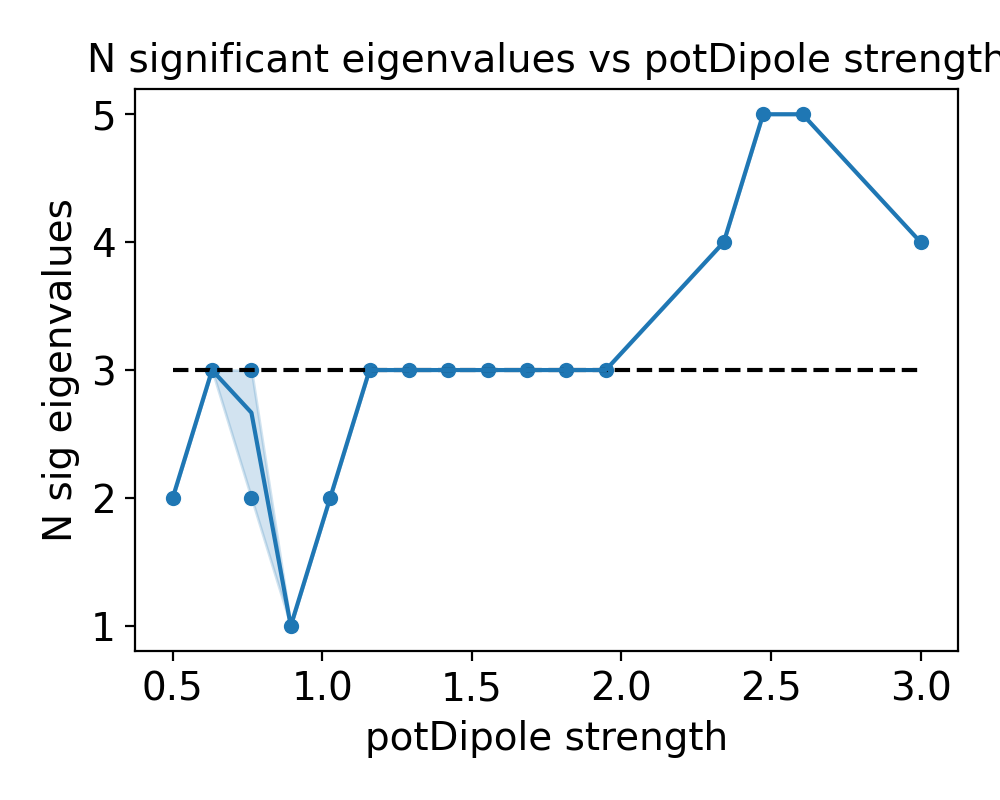

In [13]:
# Plot No:of sign eigenvalues vs parameter of interest
# plt.style.use('default')
save = False

parameter = 'potDipole strength'
title = 'N significant eigenvalues vs {}'.format(parameter)
plt.figure(figsize=(5,4))
sns.scatterplot(data = df_sig_eigenvalues, x = parameter, y = 'N sig eigenvalues', palette = 'dark')
sns.lineplot(data = df_sig_eigenvalues, x = parameter, y = 'N sig eigenvalues', markers = True, palette = 'dark')
plt.hlines(y=3, xmin=min(df_sig_eigenvalues[parameter]),xmax=max(df_sig_eigenvalues[parameter]), linestyle = '--', color = 'k')
plt.title(title)

if save:
    plt.savefig(os.path.join(publication_figures, title+'.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title+'.svg'), dpi = 300)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


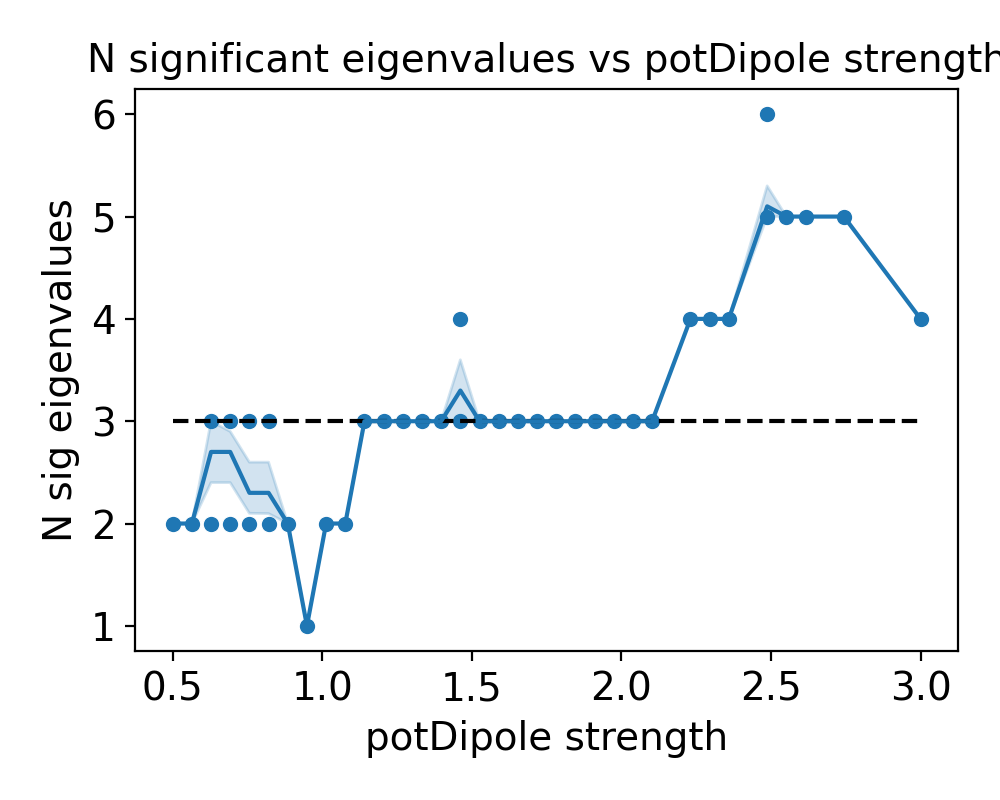

# PCA dimension (Participation ratio)

<IPython.core.display.Javascript object>


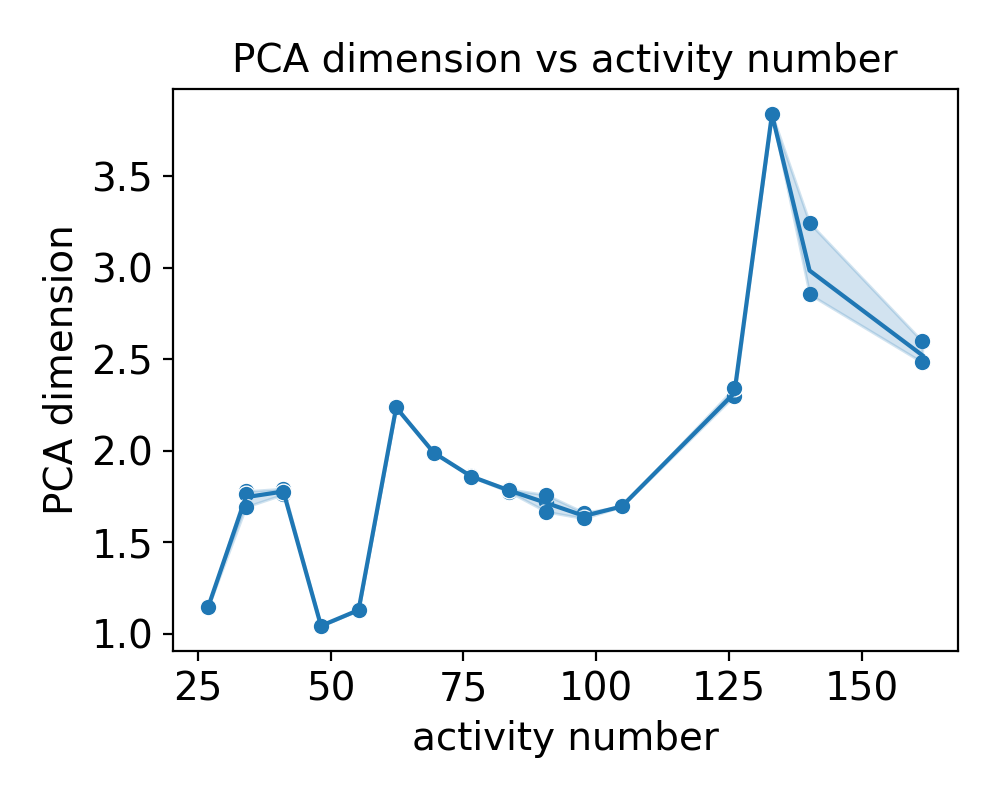

In [9]:
save = True

parameter = 'activity number'
title = 'PCA dimension vs {}'.format(parameter)
plt.figure(figsize=(5,4))
sns.scatterplot(data = df_sig_eigenvalues, x = parameter, y = 'PCA dimension', palette = 'dark')
sns.lineplot(data = df_sig_eigenvalues, x = parameter, y = 'PCA dimension', markers = True, palette = 'dark')
# plt.hlines(y=3, xmin=min(df_sig_eigenvalues[parameter]),xmax=max(df_sig_eigenvalues[parameter]), linestyle = '--', color = 'k')
plt.title(title)
plt.tight_layout()

if save:
    plt.savefig(os.path.join(publication_figures, title+'.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title+'.svg'), dpi = 300)

plt.show()

# Lyapunov exponent plot

<IPython.core.display.Javascript object>


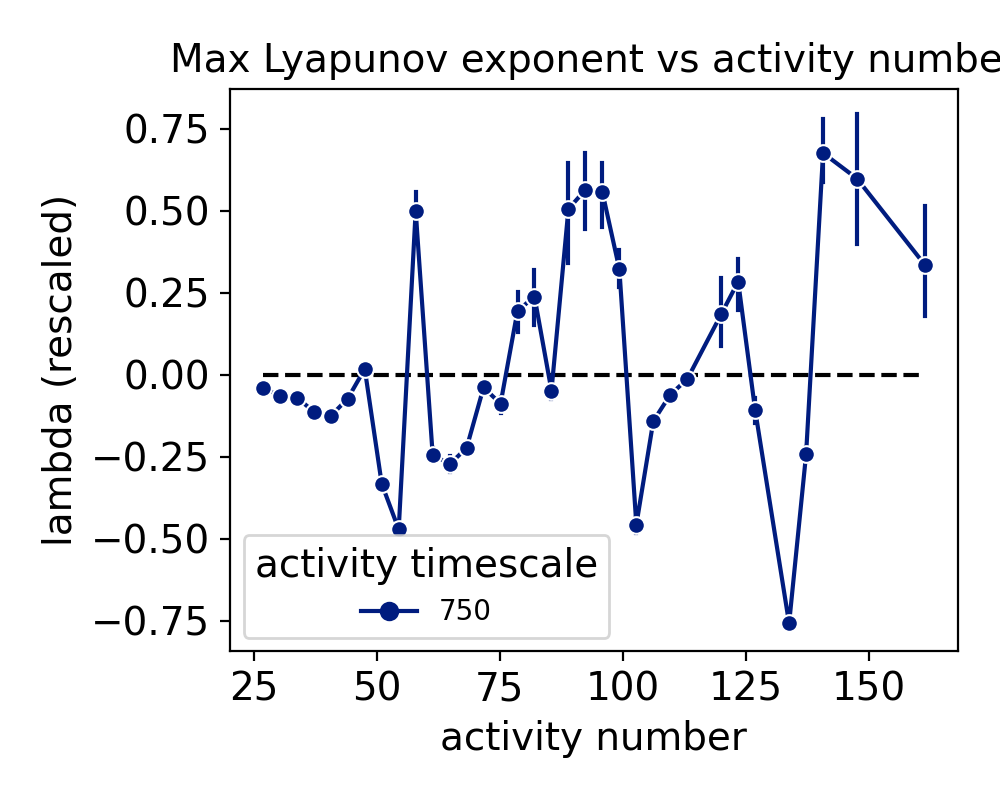

In [8]:
# plt.style.use('default')

processed_data_folder = '/home/deepak/Dropbox/LacryModeling/processed_data'
save_folder = os.path.join(processed_data_folder, 'IC_sensitivity_analysis')

parameter = 'activity number'

file_path = os.path.join(save_folder,'lyapunov_exp_vs_{}.csv'.format(parameter))


if(os.path.exists(file_path)):
    
    df_lyapunov = pd.read_csv(file_path)



# Plot the lyapunov exponent data

import seaborn as sns
%matplotlib notebook

save = False

title = 'Max Lyapunov exponent vs {}'.format(parameter)
plt.figure(figsize=(5,4))
sns.lineplot(data = df_lyapunov, x = parameter, y = 'lambda (rescaled)', style = 'activity timescale', 
             hue="activity timescale", err_style = 'bars', markers = True, color = 'r', palette = 'dark')
plt.hlines(y=0, xmin=min(df_lyapunov[parameter]),xmax=max(df_lyapunov[parameter]), linestyle = '--', color = 'k')
plt.title(title)


if save:
    plt.savefig(os.path.join(publication_figures, title+'.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title+'.svg'), dpi = 300)

plt.tight_layout()
plt.show()

In [8]:
# Calculate the typical value of the max Lyapunov exponent

lyapunov_mean = np.mean(df_lyapunov['lambda (rescaled)'].loc[df_lyapunov['lambda (rescaled)']>0])

lyapunov_min = np.min(df_lyapunov['lambda (rescaled)'].loc[df_lyapunov['lambda (rescaled)']>0])
lyapunov_max = np.max(df_lyapunov['lambda (rescaled)'].loc[df_lyapunov['lambda (rescaled)']>0])

In [11]:
print(lyapunov_mean)

print(lyapunov_min)
print(lyapunov_max)

0.38957374155691993
0.005706336290150379
1.087462138657607


## Predictability Horizon Plot

<IPython.core.display.Javascript object>


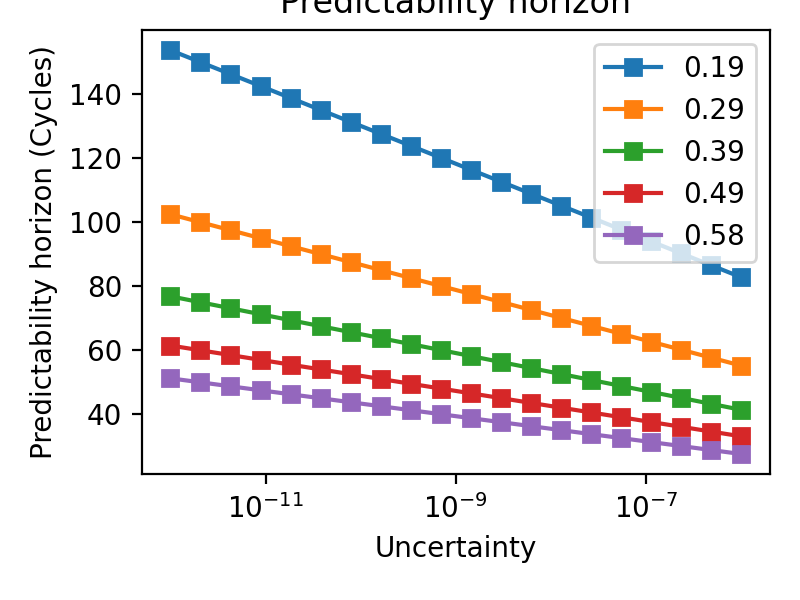

In [25]:
lyapunov_array = np.linspace(0.5*lyapunov_mean, 1.5*lyapunov_mean, 5)

tolerance = 10
delta_0_array = np.logspace(-12, -6, 20)

tau_horizon = np.zeros_like(delta_0_array)


save = True

plt.figure(figsize=(4,3))

title = 'Predictability horizon'

for lyapunov in lyapunov_array:

    tau_horizon = (1/lyapunov)*np.log(tolerance/delta_0_array)

    plt.plot(delta_0_array, tau_horizon, marker = 's', label = np.round(lyapunov,2))
    
    
plt.xlabel('Uncertainty')
plt.ylabel('Predictability horizon (Cycles)')
plt.xscale('log')
plt.tight_layout()
plt.legend()
plt.title(title)
if save:
    plt.savefig(os.path.join(publication_figures, title+'.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title+'.svg'), dpi = 300)
plt.show()

# Attractor dimension (using Correlation Integrals)

In [27]:
# Specify the data being analyzed

data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23']

In [28]:
attractor_dim_data = '/home/deepak/Dropbox/LacryModeling/processed_data/AttractorDimension/attractor_dims.csv'


if not os.path.exists(attractor_dim_data):
    # If the dataframe does not exist, then generate it



    # Find all analysis data files and create a list
    files_list = []
     # Walk through the folders and identify the simulation data files

    for data_folder in data_folders:
        for dirs, subdirs, files in os.walk(data_folder, topdown=False):

            root, subFolderName = os.path.split(dirs)

            for fileNames in files:
                if(fileNames.endswith('csv') and fileNames[0] != '.' and 'analysis' in fileNames and 'ic' not in fileNames):
                    files_list.append(os.path.join(dirs,fileNames))


    print('No:of files: {}'.format(len(files_list)))

    # Collect all data into a single data frame
    df = pd.DataFrame({})

    for file in files_list:

        df = df.append(pd.read_csv(file))
        
    # Save the attractor dim data
    df.to_csv(attractor_dim_data)
    
        
else:
    
    df = pd.read_csv(attractor_dim_data)

No:of files: 400


In [29]:
df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,N particles,radius,bond length,spring constant,kappa_hat,force strength,stresslet strength,...,period,threshold index,simulation completed,periodic dynamics,max unique locations,activity cycles completed,search efficiency,activity number,filament behavior,Correlation dimension of attractor
0,0,0.0,0.0,32,1,2.1,25,6.25,0,0,...,1.0,9,True,True,1.0,500,0.000544,37.257231,1-period,0.0
0,0,0.0,0.0,32,1,2.1,25,6.25,0,0,...,1.0,39,True,True,44.0,500,0.022121,37.257231,1-period,0.0
0,0,0.0,0.0,32,1,2.1,25,6.25,0,0,...,1.0,38,True,True,36.0,500,0.018332,37.257231,1-period,0.0
0,0,0.0,0.0,32,1,2.1,25,6.25,0,0,...,1.0,34,True,True,22.0,500,0.011509,37.257231,1-period,0.0
0,0,0.0,0.0,32,1,2.1,25,6.25,0,0,...,1.0,32,True,True,14.0,500,0.007408,37.257231,1-period,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,NaN,NaN,32,1,2.1,25,6.25,0,0,...,NaN,0,False,False,204.0,5,0.172083,154.548513,escape,NaN
0,0,NaN,NaN,32,1,2.1,25,6.25,0,0,...,NaN,0,False,False,181.0,5,0.158130,154.548513,escape,NaN
0,0,NaN,NaN,32,1,2.1,25,6.25,0,0,...,NaN,0,False,False,149.0,3,0.183273,154.548513,escape,NaN
0,0,NaN,NaN,32,1,2.1,25,6.25,0,0,...,NaN,0,False,False,293.0,12,0.122401,154.548513,escape,NaN


<IPython.core.display.Javascript object>


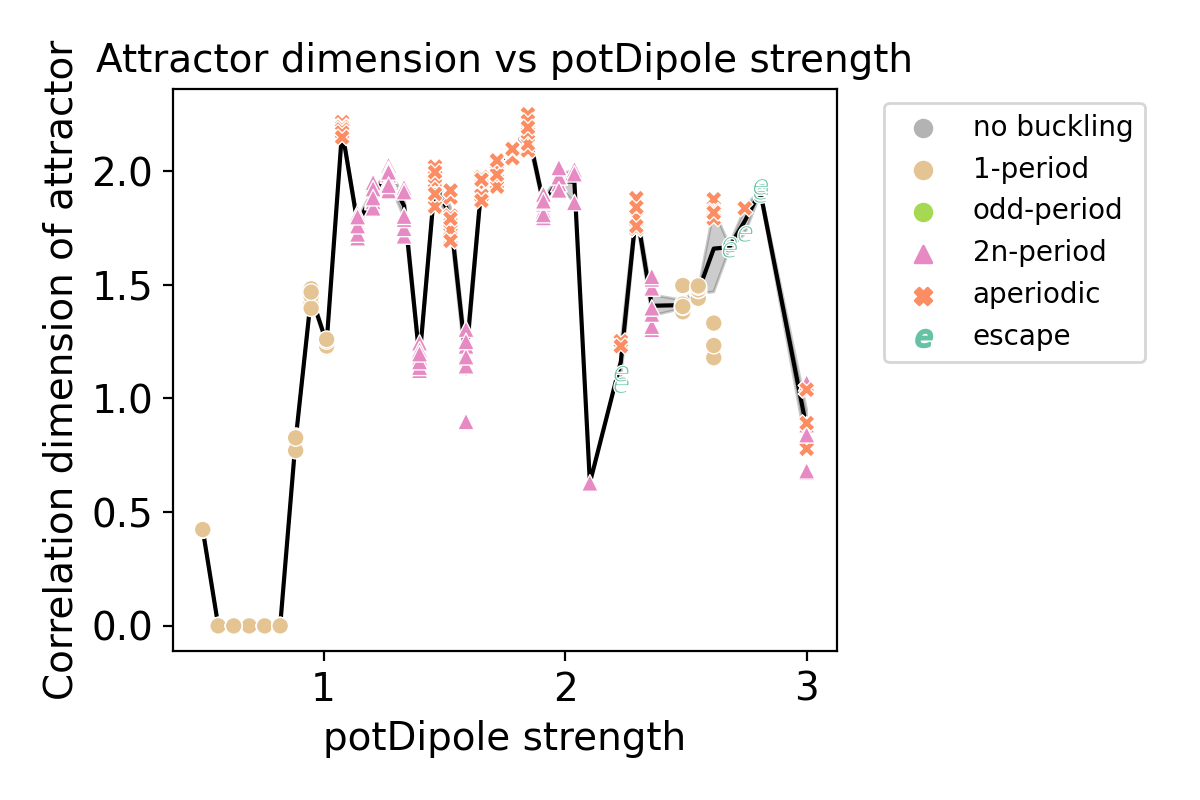

In [30]:
save = False

categories = ['no buckling', '1-period', 'odd-period','2n-period','aperiodic','escape']
markers = {'no buckling':'.', '1-period':'o','odd-period':'d','2n-period':'^','aperiodic':'X','escape':'$e$'}

cmap = plt.cm.get_cmap('Set2_r', 255)
linear_array = np.linspace(0,1,len(categories))
colors={}
for ii, cat in enumerate(categories):
    
    colors[cat]=cmap(linear_array[ii])
                           

style_parameter = 'filament behavior'

parameter = 'potDipole strength'
title = 'Attractor dimension vs {}'.format(parameter)
plt.figure(figsize=(6,4))
plt.title(title)

sns.lineplot(data = df, x = parameter, y = 'Correlation dimension of attractor', color = 'k', zorder = 0)

sns.scatterplot(data = df, x = parameter, y = 'Correlation dimension of attractor', hue = style_parameter, style = style_parameter,
             palette = colors, estimator = None, markers = markers, hue_order = categories, zorder = 1)



plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()

if save:
    plt.savefig(os.path.join(publication_figures, title+'.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title+'.svg'), dpi = 300)

plt.show()

In [41]:
# calculate the mean attractor dimension averaged across different initial condition runs

result = df.groupby(['activity number'], as_index=False).agg({'Correlation dimension of attractor':['mean', 'std'], 'filament behavior':'first'})

result

activity number Correlation dimension of attractor            \
                                                 mean       std   
0        26.908000                           0.423396  0.000011   
1        30.357744                           0.000000  0.000000   
2        33.807487                           0.000000  0.000000   
3        37.257231                           0.000000  0.000000   
4        40.706974                           0.000000  0.000000   
5        44.156718                           0.000000  0.000000   
6        47.606462                           0.818579  0.017707   
7        51.056205                           1.450601  0.029810   
8        54.505949                           1.244463  0.014057   
9        57.955692                           2.177704  0.021302   
10       61.405436                           1.768286  0.039257   
11       64.855179                           1.899343  0.037403   
12       68.304923                           1.977543  0.036051   
13       71.754667                           1.847186  0.084936   
14       75.204410                           1.175031  0.040463   
15       78.654154                           1.954075  0.050165   
16       82.103897                           1.795676  0.083961   
17       85.553641                           1.175321  0.108950   
18       89.003385                           1.938380  0.039502   
19       92.453128                           2.006179  0.041336   
20       95.902872                           2.084561  0.015683   
21       99.352615                           2.175635  0.047816   
22      102.802359                           1.859679  0.038338   
23      106.252103                           1.958366  0.040269   
24      109.701846                                NaN       NaN   
25      109.701846                           1.952057  0.078824   
26      113.151590                           0.628562       NaN   
27      116.601333                                NaN       NaN   
28      120.051077                           1.162143  0.093469   
29      123.500821                           1.824683  0.058455   
30      126.950564                           1.407406  0.081419   
31      130.400308                                NaN       NaN   
32      133.850051                           1.410546  0.031472   
33      137.299795                           1.470405  0.017282   
34      140.749538                           1.658782  0.287177   
35      144.199282                           1.664928  0.015735   
36      147.649026                           1.779627  0.079394   
37      151.098769                           1.910442  0.014681   
38      154.548513                                NaN       NaN   
39      157.998256                                NaN       NaN   
40      161.448000                           0.867661  0.144528   

   filament behavior  
               first  
0           1-period  
1           1-period  
2           1-period  
3           1-period  
4           1-period  
5           1-period  
6           1-period  
7           1-period  
8           1-period  
9          aperiodic  
10         2n-period  
11         2n-period  
12         2n-period  
13         2n-period  
14         2n-period  
15         aperiodic  
16         aperiodic  
17         2n-period  
18         aperiodic  
19         aperiodic  
20         aperiodic  
21         aperiodic  
22         2n-period  
23         2n-period  
24            escape  
25         2n-period  
26            escape  
27            escape  
28            escape  
29         aperiodic  
30         2n-period  
31            escape  
32          1-period  
33          1-period  
34         aperiodic  
35            escape  
36            escape  
37            escape  
38            escape  
39            escape  
40         aperiodic

In [40]:
result['filament behavior']

,first
activity number,
26.908000,1-period
30.357744,1-period
33.807487,1-period
37.257231,1-period
40.706974,1-period
44.156718,1-period
47.606462,1-period
51.056205,1-period
54.505949,1-period
